# 1. Imports and Definitions

## Library Downloads

In [1]:
!pip install -q wandb

     |████████████████████████████████| 2.1MB 18.5MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 133kB 57.8MB/s 
     |████████████████████████████████| 163kB 56.4MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 


## Imports

In [2]:
# generic libs
import numpy as np
import json
import glob
import matplotlib.pyplot as plt

# ML-specific libs
import tensorflow as tf
ks = tf.keras
from sklearn.model_selection import train_test_split

# WandB
import wandb
from wandb.keras import WandbCallback as WandbCallback

## mount Google Drive (for iNaturalist 12K dataset)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Harness Functions

In [4]:
# initialize model from JSON-style config object
def initModel(config):
  # create layer list
  layers = []

  for lconf in config["layers"]:
    ltype = lconf["type"]
    if   ltype=="input":
      layers.append(ks.Input( 
        shape = lconf["size"]
      ) )
    
    elif ltype=="conv":
      layers.append( ks.layers.Conv2D( 
        lconf["filter_num"],
        lconf["filter_size"], 
        strides = lconf["stride"],
        activation = lconf["activation"] 
      ) )
    
    elif ltype=="pool":
      layers.append( ks.layers.MaxPooling2D( 
        pool_size=lconf["size"] 
      ) )
    
    elif ltype=="fc":
      layers.append( ks.layers.Dense( 
        lconf["size"], 
        activation = lconf["activation"]
      ) )
    
    elif ltype=="flatten":
      layers.append( ks.layers.Flatten() )
    
    elif ltype=="dropout":
      layers.append( ks.layers.Dropout(
        lconf["fraction"]
      ) )
    
    elif ltype=="batchnorm":
      if "perform" in lconf:
        if lconf["perform"]==True:
          layers.append( ks.layers.BatchNormalization() )
      else:
        layers.append( ks.layers.BatchNormalization() )
    
    elif ltype=="exec":
      exec("lexec=ks.layers."+lconf["expr"])
      layers.append(locals()["lexec"])

  model = ks.Sequential(layers)

  # compile and return model for given hyperparameters
  exec( "optexec=ks.optimizers." + config["optimizer"]) #* revise based on final storage pattern used
  opt = locals()["optexec"]
  model.compile( optimizer = opt, loss = config["loss"], metrics = ["accuracy"])
  return model

def trainingRun(config, **kwargs):
  model = initModel(config)
  tp = config["trainparams"]

  # set up WandB callback to train function
  callbacks=[]
  
  try:
    if config["wandb"]:
      callbacks.append(
        WandbCallback(
          monitor="val_accuracy", save_model=True
        )
      )
    else: print("Warning: not using WandB")
  except KeyError: print("Warning: not using WandB")
  
  # run training loop for given number of epochs
  if all([_ in kwargs for _ in ["xdata","ydata"]]):
    model.fit(kwargs["xdata"], kwargs["ydata"], epochs = tp["epochs"], batch_size = tp["batch_size"], validation_split = tp["val_split"], callbacks = callbacks)
  elif all([_ in kwargs for _ in ["train_data","val_data"]]):
    model.fit(kwargs["train_data"], validation_data = kwargs["val_data"], epochs = tp["epochs"], batch_size = tp["batch_size"], callbacks = callbacks)
  else: raise AssertionError("improper arguments given")

# 3. Dataset Initialization and Reshaping

## MNIST digit dataset

In [ ]:
# import MNIST dataset
((x_train, y_train), (x_test, y_test)) = ks.datasets.mnist.load_data()

# pad with zeros and convert to 32x32 LeNet-5 input
x_train = np.pad(x_train,((0,0),(2,2),(2,2))).reshape((len(x_train),32,32,1))
x_test = np.pad(x_test,((0,0),(2,2),(2,2))).reshape((len(x_test),32,32,1))

# convert to float and normalize
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# one hot encode target values
y_train = ks.utils.to_categorical(y_train)
y_test = ks.utils.to_categorical(y_test)

## iNaturalist 12K dataset

In [4]:
inaturalist_train_root = "/content/drive/MyDrive/Sem 8/DL/inaturalist_12K/train"
inaturalist_test_root = "/content/drive/MyDrive/Sem 8/DL/inaturalist_12K/val"

def augmentImage(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  return image, label

def I12kDatasets(config):
  img_dims = (800,800,3)

  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inaturalist_train_root,
    validation_split=config["trainparams"]["val_split"],
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=img_dims[:2],
    batch_size=config["trainparams"]["batch_size"])

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inaturalist_train_root,
    validation_split=config["trainparams"]["val_split"],
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=img_dims[:2],
    batch_size=config["trainparams"]["batch_size"])

  if "dsAugment" in config["trainparams"] and config["trainparams"]["dsAugment"]==True:
    train_ds = train_ds.map(augmentImage,num_parallel_calls=tf.data.AUTOTUNE)
    val_ds   = val_ds.map(augmentImage,num_parallel_calls=tf.data.AUTOTUNE)
    
  train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  val_ds   = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  
  return train_ds, val_ds

def I12kDatasets_test(config):
  img_dims = (800,800,3)

  test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inaturalist_test_root,
    label_mode="categorical",
    image_size=img_dims[:2],
    batch_size=config["trainparams"]["batch_size"])
  
  return test_ds

# 4. Running A Configuration

## Run-helper functions

In [ ]:
# create config object from JSON file
def configFromJSON(arg):
  # input checks
  argtype = type(arg).__name__
  config = None
  if   argtype=="str":
    config = json.load(open(arg,'r')) #* add failsafe
  elif argtype=="TextIOWrapper":
    config = json.load(arg)
  elif argtype=="dict":
    config = arg
  return config

## Sample runs

In [ ]:
wandb.init(project="CNN MNIST Test Runs")
run_config = configFromJSON("lenet5.json")
trainingRun(run_config, xdata=x_train, ydata=y_train)

# 5. Sweeps

## Functions

In [ ]:
# create config object for WandB sweep (Assignment 2 architecture)
def configForA2WandbSweep():
  wcfg = wandb.config
  return { "layers": [
    {
      "type": "exec",
      "expr": "experimental.preprocessing.Rescaling(1./255)"
    },
    {
      "type": "conv",
      "filter_num": wcfg.layer_1_filter_num,
      "filter_size": wcfg.layer_1_filter_size,
      "stride": wcfg.layer_1_stride,
      "activation": wcfg.layer_1_activation
    },
    {
      "type": "batchnorm",
      "perform": wcfg.bn_perform
    },
    {
      "type": "pool",
      "size": wcfg.layer_1_pool_size
    },
    {
      "type": "conv",
      "filter_num": wcfg.layer_2_filter_num,
      "filter_size": wcfg.layer_2_filter_size,
      "stride": wcfg.layer_2_stride,
      "activation": wcfg.layer_2_activation
    },
    {
      "type": "batchnorm",
      "perform": wcfg.bn_perform
    },
    {
      "type": "pool",
      "size": wcfg.layer_2_pool_size
    },
    {
      "type": "conv",
      "filter_num": wcfg.layer_3_filter_num,
      "filter_size": wcfg.layer_3_filter_size,
      "stride": wcfg.layer_3_stride,
      "activation": wcfg.layer_3_activation
    },
    {
      "type": "batchnorm",
      "perform": wcfg.bn_perform
    },
    {
      "type": "pool",
      "size": wcfg.layer_3_pool_size
    },
    {
      "type": "conv",
      "filter_num": wcfg.layer_4_filter_num,
      "filter_size": wcfg.layer_4_filter_size,
      "stride": wcfg.layer_4_stride,
      "activation": wcfg.layer_4_activation
    },
    {
      "type": "batchnorm",
      "perform": wcfg.bn_perform
    },
    {
      "type": "pool",
      "size": wcfg.layer_4_pool_size
    },
    {
      "type": "conv",
      "filter_num": wcfg.layer_5_filter_num,
      "filter_size": wcfg.layer_5_filter_size,
      "stride": wcfg.layer_5_stride,
      "activation": wcfg.layer_5_activation
    },
    {
      "type": "batchnorm",
      "perform": wcfg.bn_perform
    },
    {
      "type": "pool",
      "size": wcfg.layer_5_pool_size
    },
    {
      "type": "flatten"
    },
    {
      "type": "dropout",
      "fraction": wcfg.layer_6_dropout
    },
    {
      "type": "fc",
      "size": wcfg.layer_6_size,
      "activation": wcfg.layer_6_activation
    },
    {
      "type": "dropout",
      "fraction": wcfg.layer_7_dropout
    },
    {
      "type": "fc",
      "size": wcfg.layer_7_size,
      "activation": wcfg.layer_7_activation
    }
    #* add dropout at strategic location
    ],
    "optimizer": wcfg.optimizer,
    "loss": wcfg.loss,
    "trainparams": {
      "epochs": wcfg.epochs,
      "batch_size": wcfg.batch_size,
      "val_split": wcfg.val_split,
    "dsAugment": wcfg.dsAugment
    },
    "wandb": True
  }

def runWandbSweep():
  wandb.init(resume="allow")
  # obtain config and base(i.e. un-augmented) datasets
  run_config = configForA2WandbSweep()
  train_dataset, val_dataset = I12kDatasets(run_config)
  
  # perform training run
  trainingRun(run_config, train_data=train_dataset, val_data=val_dataset)

In [ ]:
r_config = configFromJSON("A2arch.json")
train_dataset, val_dataset = I12kDatasets(r_config)

# perform training run
trainingRun(r_config, train_data=train_dataset, val_data=val_dataset)

## Configure and run sweep

In [ ]:
wandbSweepCfg = {
  "name":"iNaturalist Parameter Sweep", 
  "metric":{
    "name":"val_accuracy",
    "goal":"maximize"
  }, 
  "method": "bayes", 
  "parameters":{
    # layer parameters
    "layer_1_filter_num": { "values": [8,16,32] },
    "layer_1_filter_size": { "values": [3,7] },
    "layer_1_stride": { "values": [1] },
    "layer_1_activation": { "values": ["relu"] },
    #"layer_1_bn_perform": { "values": [False] },
    "layer_1_pool_size": { "values": [2] },

    "layer_2_filter_num": { "values": [8,16,32] },
    "layer_2_filter_size": { "values": [3,7] },
    "layer_2_stride": { "values": [1] },
    "layer_2_activation": { "values": ["relu"] },
    #"layer_2_bn_perform": { "values": [False] },
    "layer_2_pool_size": { "values": [2] },

    "layer_3_filter_num": { "values": [8,16,32] },
    "layer_3_filter_size": { "values": [3,7] },
    "layer_3_stride": { "values": [1] },
    "layer_3_activation": { "values": ["relu"] },
    #"layer_3_bn_perform": { "values": [False] },
    "layer_3_pool_size": { "values": [2] },

    "layer_4_filter_num": { "values": [8,16,32] },
    "layer_4_filter_size": { "values": [3,7] },
    "layer_4_stride": { "values": [1] },
    "layer_4_activation": { "values": ["relu"] },
    #"layer_4_bn_perform": { "values": [False] },
    "layer_4_pool_size": { "values": [2] },

    "layer_5_filter_num": { "values": [8,16,32] },
    "layer_5_filter_size": { "values": [3,7] },
    "layer_5_stride": { "values": [1] },
    "layer_5_activation": { "values": ["relu"] },
    #"layer_5_bn_perform": { "values": [False] },
    "layer_5_pool_size": { "values": [2] },
    
    "layer_6_dropout": { "values": [0,0.2,0.3] },
    "layer_6_size": { "values": [64, 96, 128] },
    "layer_6_activation": { "values": ["tanh"] },

    "layer_7_dropout": { "values": [0,0.2,0.3] },
    "layer_7_size": { "values": [10] },
    "layer_7_activation": { "values": ["softmax"] },

    "bn_perform": { "values": [False, True] },

    # optimizer and loss
    "optimizer": { "values": ["Adam()"] },
    "loss": { "values": ["categorical_crossentropy"] },

    # training parameters
    "epochs": { "values":[20] },
    "batch_size": { "values":[32] },
    "val_split": { "values": [0.1] },
    "dsAugment": { "values": [False, True]}
  }
}

sweepId = "vasid99/uncategorized/uklnmska"#wandb.sweep(wandbSweepCfg)
wandb.agent(sweepId, function = runWandbSweep)

# Q4 (a) Using test data on the best model

In [ ]:
hyp = { 
    "layers": [
    {
      "type": "exec", 
      "expr": "experimental.preprocessing.Rescaling(1./255)"
    },
    {
      "type": "conv",
      "filter_num": 64,
      "filter_size": [11,11],
      "stride": 1,
      "activation": "relu"
    },
    {
      "type": "batchnorm",
      "perform": True
    },
    {
      "type": "pool",
      "size": 2
    },
    {
      "type": "conv",
      "filter_num": 32,
      "filter_size": [7,7],
      "stride": 1,
      "activation": "relu"
    },
    {
      "type": "batchnorm",
      "perform": True
    },
    {
      "type": "pool",
      "size": 2
    },
    {
      "type": "conv",
      "filter_num": 32,
      "filter_size": [7,7],
      "stride": 1,
      "activation": "relu"
    },
    {
      "type": "batchnorm",
      "perform": True
    },
    {
      "type": "pool",
      "size": 2
    },
    {
      "type": "conv",
      "filter_num": 32,
      "filter_size": [7,7],
      "stride": 1,
      "activation": "relu"
    },
    {
      "type": "batchnorm",
      "perform": True
    },
    {
      "type": "pool",
      "size": 2
    },
    {
      "type": "conv",
      "filter_num": 16,
      "filter_size": [3,3],
      "stride": 1,
      "activation": "relu"
    },
    {
      "type": "batchnorm",
      "perform": True
    },
    {
      "type": "pool",
      "size": 2
    },
    {
      "type": "flatten"
    },
    {
      "type": "dropout",
      "fraction": 0
    },
    {
      "type": "fc",
      "size": 96,
      "activation": "tanh"
    },
    {
      "type": "dropout",
      "fraction": 0.3
    },
    {
      "type": "fc",
      "size": 10,
      "activation": "softmax"
    }
    ],
    "optimizer": "Adam()",
    "loss": "categorical_crossentropy",
    "trainparams": {
      "epochs": 30,
      "batch_size": 32,
      "val_split": 0.1,
      "dsAugment": True
    },
    "wandb": True
  }

train_dataset, val_dataset = I12kDatasets(hyp)

wandb.init(project="CNN iNat Test Runs")

# perform training run
trainingRun(hyp, train_data=train_dataset, val_data=val_dataset)

#model = ks.models.load_model("/content/drive/MyDrive/Sem 8/DL/model-best.h5")

test_dataset = I12kDatasets_test(hyp)
class_names = test_dataset.class_names 

In [ ]:
metrics = model.evaluate(test_dataset, callbacks=[WandbCallback()], return_dict=True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


63/63 [==============================] - 1496s 21s/step - loss: 1.9398 - accuracy: 0.3040


{'accuracy': 0.30399999022483826, 'loss': 1.9397568702697754}

# Q4 (b) Sample Images with predictions

In [12]:
test_sub_ds = test_dataset.take(1)
test_sub = list(test_sub_ds.as_numpy_iterator())
X_test_sub = np.array(test_sub[0][0])[:30]
Y_test_sub = np.argmax(np.array(test_sub[0][1])[:30], axis=1)

Y_pred = np.argmax(model.predict(test_sub_ds), axis=1)[:30]
print(np.count_nonzero(Y_test_sub==Y_pred))

5


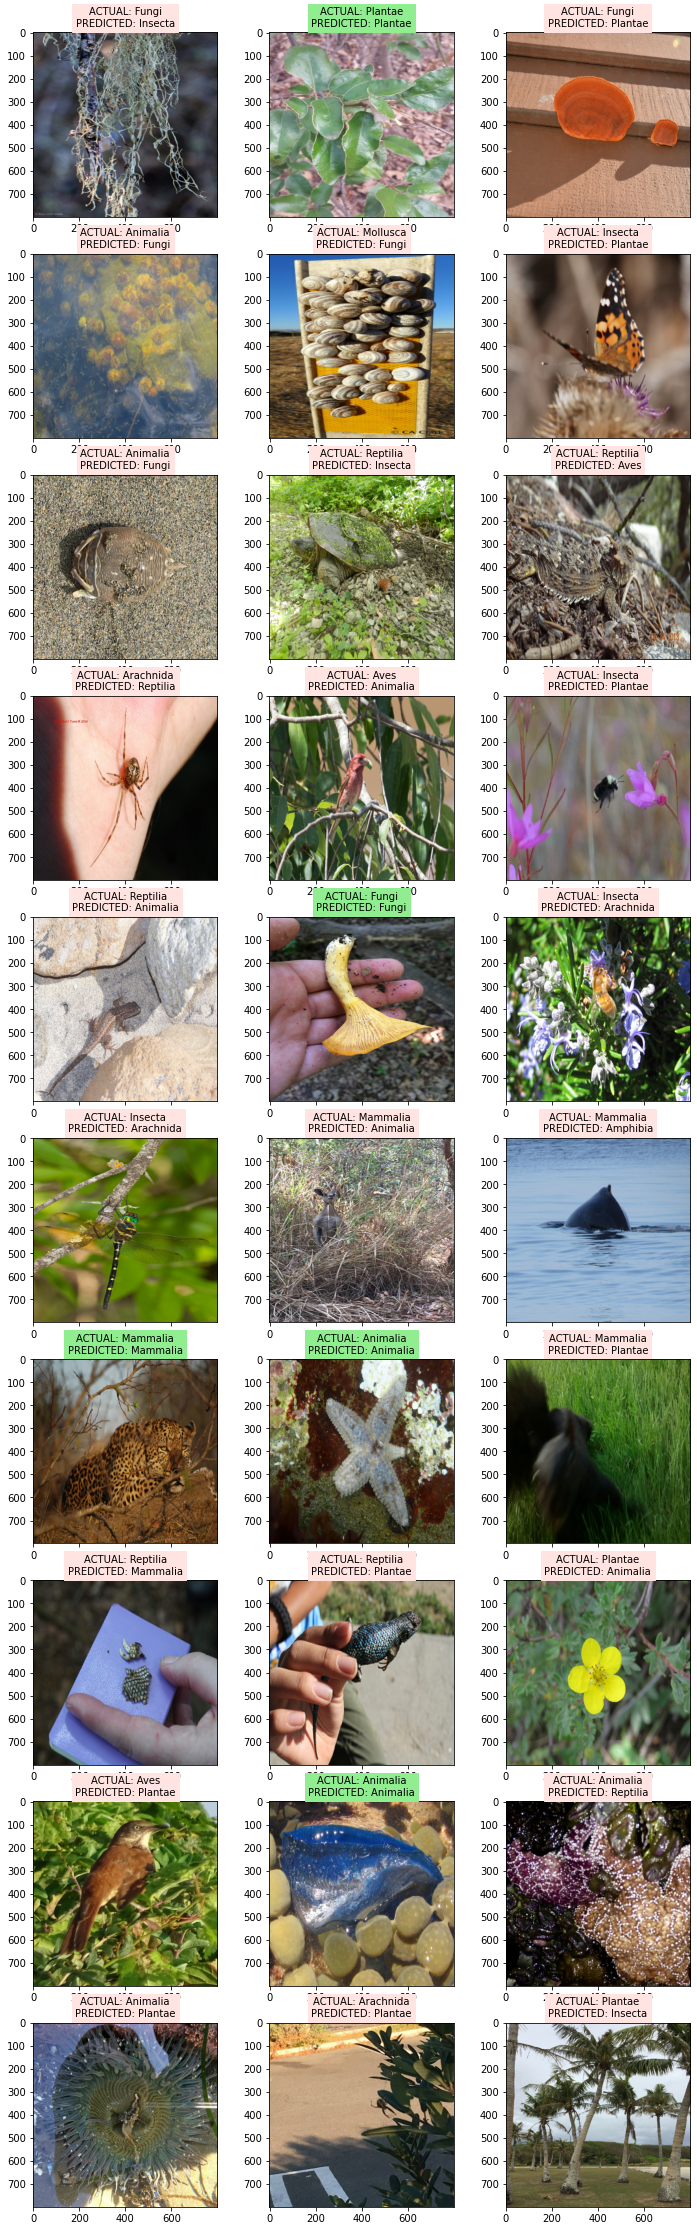

In [18]:
fig1, ax = plt.subplots(10, 3, figsize=(12,40))
for i in range(30):
    pos = (i//3, i%3)
    actual = class_names[Y_test_sub[i]]
    pred = class_names[Y_pred[i]]
    ax[pos].imshow(X_test_sub[i]/255)
    if pred == actual:
        ax[pos].set_title('ACTUAL: '+actual+'\nPREDICTED: '+pred, backgroundcolor='lightgreen', size=10)
    else:
        ax[pos].set_title('ACTUAL: '+actual+'\nPREDICTED: '+pred, backgroundcolor='mistyrose', size=10)
plt.show()

In [19]:
#wandb.init(project="CNN iNat Test Runs")
wandb.log({"Sample Images iNaturalist": wandb.Image(fig1)})

# Q4 (c) Filters in the first layer

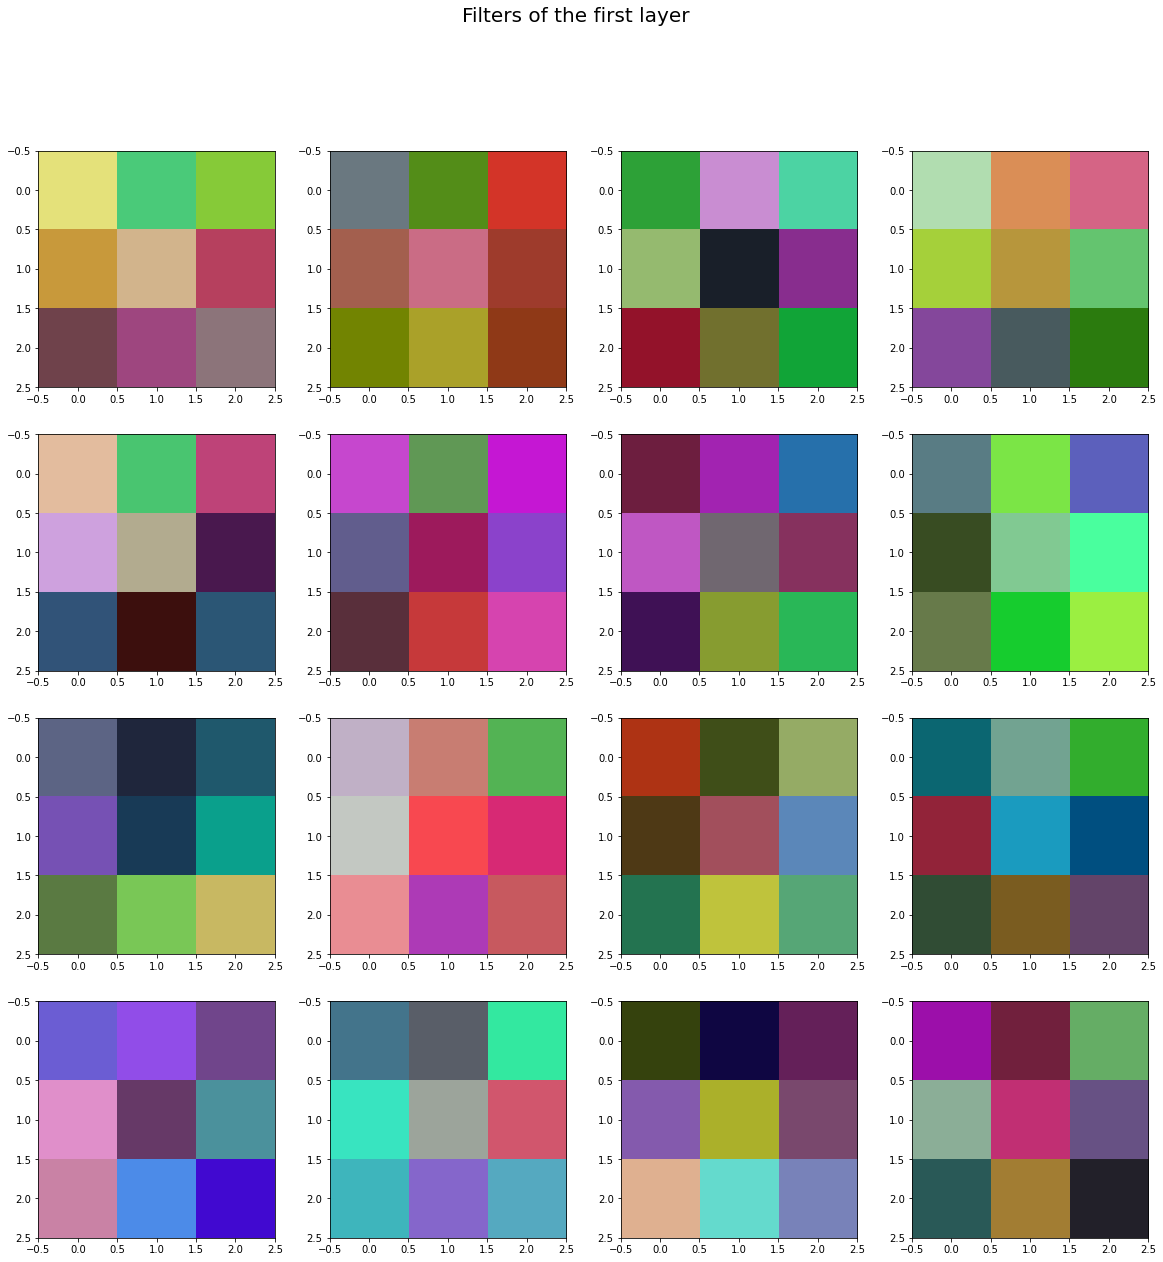

In [22]:
filters, biases = model.layers[1].get_weights()
num_filters = filters.shape[-1]

filters = (filters - filters.min())/(filters.max()-filters.min())

grid_f_x = int(np.ceil(num_filters**0.5))
grid_f_y = num_filters//grid_f_x
fig2, ax = plt.subplots(grid_f_y, grid_f_x, figsize=(20,20))
for i in range(num_filters):
    ax[i//grid_f_x, i%grid_f_x].imshow(filters[:,:,:,i])
fig2.suptitle('Filters of the first layer', size=20)
plt.show() 

In [23]:
wandb.log({"Filters of the first layer": wandb.Image(fig2)})

# Q5 Guided backpropagation

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 800, 800, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 798, 798, 16)      448       
_________________________________________________________________
batch_normalization_5 (Batch (None, 798, 798, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 399, 399, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 393, 393, 32)      25120     
_________________________________________________________________
batch_normalization_6 (Batch (None, 393, 393, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 196, 196, 32)     

In [ ]:
conv5layer = model.layers[-5]
num_neurons = conv5layer.output_shape[1]

feature_extractor = ks.Model(
    inputs=model.inputs,
    outputs=conv5layer.output,
)

X = tf.constant(np.expand_dims(X_test_sub[13], axis=0))

norms = np.array([])

for i in range(num_neurons//30):
  with tf.GradientTape() as t:
    t.watch(X)
    Y_full = feature_extractor(X)
    Y = Y_full[0][i:i+30]
  dy_dx = np.clip(t.jacobian(Y, X).numpy(), 0, None)
  norm = np.linalg.norm(np.linalg.norm(dy_dx, axis=(3,4)), axis=(1,2))
  norms = np.append(norms, norm)

chosen_ids = np.argsort(norms)[-10:]

with tf.GradientTape() as t:
  t.watch(X)
  Y_full = feature_extractor(X)
  Y = tf.gather(Y_full[0], chosen_ids)

dy_dx = t.jacobian(Y, X).numpy()

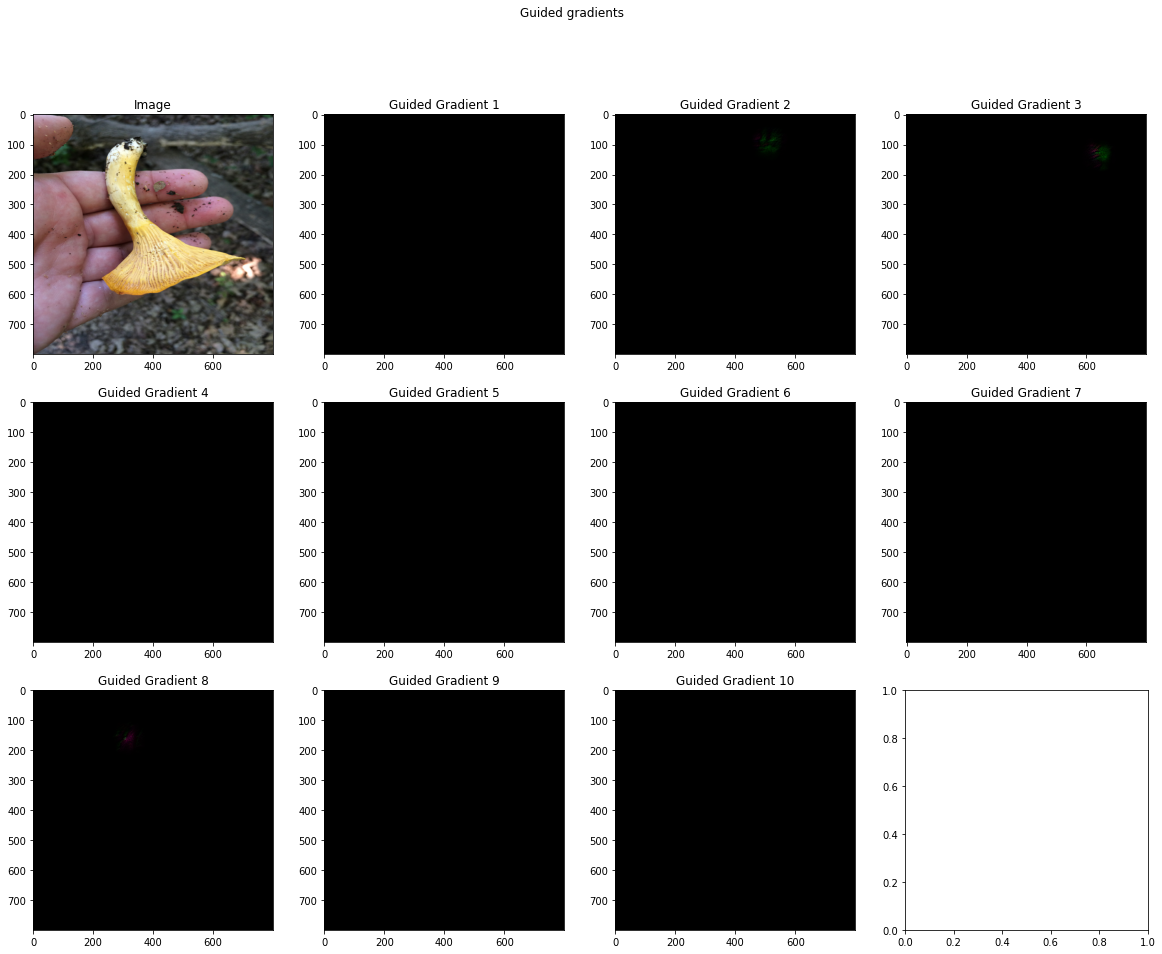

In [60]:
grad = dy_dx[:,0,:,:,:]
grad_guided = np.clip(grad, 0, None)

grad_guided = grad_guided/grad_guided.max()

num_outs = dy_dx.shape[0]
grid_x = int(np.ceil(num_outs**0.5))
grid_y = num_outs//grid_x
fig3, ax = plt.subplots(grid_y+1, grid_x, figsize=(20,15))
fig3.suptitle('Guided gradients')
ax[0,0].imshow(X[0]/255)
ax[0,0].set_title('Image')
for i in range(num_outs):
    pos = ((i+1)//grid_x, (i+1)%grid_x)
    ax[pos].imshow(grad_guided[i])
    ax[pos].set_title('Guided Gradient '+str(i+1))
plt.show()  

In [62]:
wandb.log({"Guided backpropagation": wandb.Image(fig3)})